# 分析航空公司的实时飞行性能和航班延误的原因
1. 简单地建立评价航空公司实时飞行性能的指标：航班延误总数
2. 分析和航班延误的相关变量

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("flightsDA").getOrCreate()

## 1. 导入数据集


In [15]:
airports_file_path = "./data/airport-codes-na.txt"
flights_file_path = "./data/departuredelays.csv"

# 读取机场数据集: txt文本，分隔符是'\t'
airports = spark.read.csv(airports_file_path, header='true', inferSchema='true', sep='\t')
airports.createOrReplaceTempView("airports")

# 读取起飞延迟数据
flight_perf = spark.read.csv(flights_file_path, header='true')
flight_perf.createOrReplaceTempView("flightPerformance")
# 缓存起飞延迟数据集
flight_perf.cache()

DataFrame[date: string, delay: string, distance: string, origin: string, destination: string]

## 2. 数据初探
1. 机场数据集：机场的地理位置信息，国际航空运输协会机场代码IATA
2. 飞机延时数据表：日期，延时时长(双极性)，起点到目的地距离，起点的IATA代码，目的地的IATA代码

In [16]:
airports.show(10)

+-----------+-----+-------+----+
|       City|State|Country|IATA|
+-----------+-----+-------+----+
| Abbotsford|   BC| Canada| YXX|
|   Aberdeen|   SD|    USA| ABR|
|    Abilene|   TX|    USA| ABI|
|      Akron|   OH|    USA| CAK|
|    Alamosa|   CO|    USA| ALS|
|     Albany|   GA|    USA| ABY|
|     Albany|   NY|    USA| ALB|
|Albuquerque|   NM|    USA| ABQ|
| Alexandria|   LA|    USA| AEX|
|  Allentown|   PA|    USA| ABE|
+-----------+-----+-------+----+
only showing top 10 rows



In [17]:
flight_perf.show(10)

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
|01020605|   -4|     602|   ABE|        ATL|
|01031245|   -4|     602|   ABE|        ATL|
|01030605|    0|     602|   ABE|        ATL|
|01041243|   10|     602|   ABE|        ATL|
|01040605|   28|     602|   ABE|        ATL|
|01051245|   88|     602|   ABE|        ATL|
|01050605|    9|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 10 rows



## 3. 简单的飞行性能指标：飞机航班延误总数

1. 首先，要返回的是从华盛顿州发出的航班，每个城市名，出发地IATA代码，和总共延时时长，
2. 按照时长降序排列
3. 先让表airports中的每一项加入到能与a.IATA相等的flightPerformance.origin所在行，
4. 也就是说给flightPerformance表中每一行的origin项扩充地理位置信息。
5. 之后再对扩充了地理位置信息的表进行聚合，按照关键字a.City, f.origin
6. 最后对聚合的组内数据求和sum(f.delay)，并按照sum(f.delay)降序排列

In [18]:
# 查询从华盛顿州起飞的飞机航班延误总数
spark.sql(""" 
select a.City, f.origin, sum(f.delay) as Delays
from flightPerformance f
join airports a
on a.IATA = f.origin 
where a.State = 'WA'
group by a.City, f.origin
order by sum(f.delay) desc""").show()

+-------+------+--------+
|   City|origin|  Delays|
+-------+------+--------+
|Seattle|   SEA|159086.0|
|Spokane|   GEG| 12404.0|
|  Pasco|   PSC|   949.0|
+-------+------+--------+



In [27]:
wa_flight_perf = spark.sql(""" 
select a.City, f.origin, sum(f.delay) as Delays
from flightPerformance f
join airports a
on a.IATA = f.origin 
where a.State = 'WA'
group by a.City, f.origin
order by sum(f.delay) desc""")

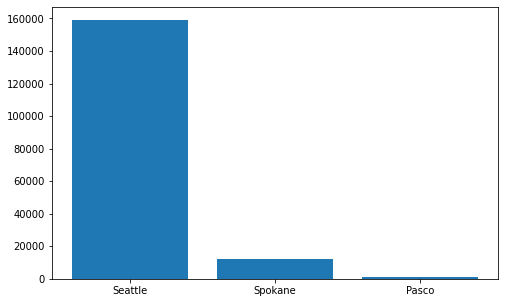

In [43]:
import matplotlib.pyplot as plt

# spark DataFrame 转换成pandas Dataframe
df_pandas = wa_flight_perf.toPandas()

plt.figure(figsize=(8,5))
plt.bar(df_pandas['City'], df_pandas['Delays'])
plt.show()

### 3.2 USA的航班性能

In [47]:
usa_flight_perf = spark.sql(""" 
select a.State, sum(f.delay) as Delays
from flightPerformance f
join airports a
on a.IATA = f.origin 
where a.Country = 'USA'
group by a.State""")

In [49]:
usa_flight_perf.show()

+-----+---------+
|State|   Delays|
+-----+---------+
|   SC|  80666.0|
|   AZ| 401793.0|
|   LA| 199136.0|
|   MN| 256811.0|
|   NJ| 452791.0|
|   OR| 109333.0|
|   VA|  98016.0|
| null| 397237.0|
|   RI|  30760.0|
|   WY|  15365.0|
|   KY|  61156.0|
|   NH|  20474.0|
|   MI| 366486.0|
|   NV| 474208.0|
|   WI| 152311.0|
|   ID|  22932.0|
|   CA|1891919.0|
|   CT|  54662.0|
|   NE|  59376.0|
|   MT|  19271.0|
+-----+---------+
only showing top 20 rows



In [50]:
usa_flight_perf_nonull = usa_flight_perf.dropna()
usa_flight_perf_nonull.show()

+-----+---------+
|State|   Delays|
+-----+---------+
|   SC|  80666.0|
|   AZ| 401793.0|
|   LA| 199136.0|
|   MN| 256811.0|
|   NJ| 452791.0|
|   OR| 109333.0|
|   VA|  98016.0|
|   RI|  30760.0|
|   WY|  15365.0|
|   KY|  61156.0|
|   NH|  20474.0|
|   MI| 366486.0|
|   NV| 474208.0|
|   WI| 152311.0|
|   ID|  22932.0|
|   CA|1891919.0|
|   CT|  54662.0|
|   NE|  59376.0|
|   MT|  19271.0|
|   NC| 394256.0|
+-----+---------+
only showing top 20 rows



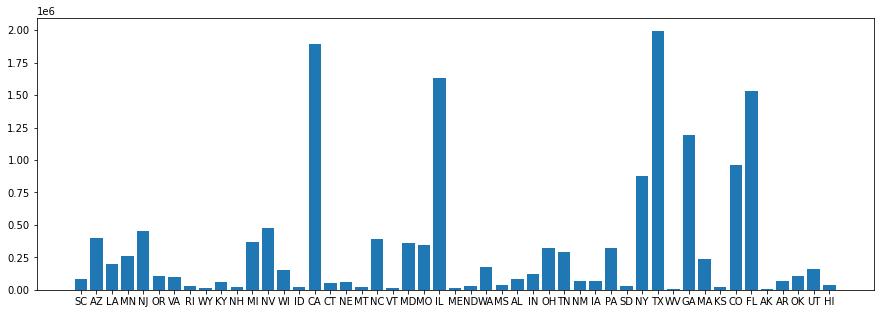

In [53]:
import matplotlib.pyplot as plt
# spark DataFrame 转换成pandas Dataframe
df_pandas = usa_flight_perf_nonull.toPandas()

plt.figure(figsize=(15,5))
plt.bar(df_pandas['State'], df_pandas['Delays'])
plt.show()